# Binary segmentation

In [14]:
import numpy as np
import tensorflow as tf
import argparse
import os
from glob import glob

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import numpy as np
import tensorflow as tf
from keras.utils import Sequence
from albumentations import ShiftScaleRotate, Flip, GridDistortion
import cv2
import os

class MyGenerator(Sequence):
    def __init__(self, imgs, msks, img_path, msk_path, weights, batch_size=2, to_fit=True, train=True, shuffle=True):
        self.batch_size = batch_size
        self.idxs = np.arange(len(imgs))
        self.to_fit = to_fit
        self.train = train
        self.shuffle = shuffle
        self.imgs = imgs
        self.msks = msks
        self.weights = weights
        self.img_path = img_path
        self.msk_path = msk_path

    def __len__(self):
        return int(np.ceil(len(self.imgs) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.idxs)

    def load_Xy(self, batch):
        X = []
        y = []
        w = []
        for i in batch:
            img_path = os.path.join(self.img_path, self.imgs[i])
            msk_path = os.path.join(self.msk_path, self.msks[i])

            if not os.path.exists(img_path):
                print(f"Image file not found: {img_path}")
                continue
            if not os.path.exists(msk_path):
                print(f"Mask file not found: {msk_path}")
                continue

            img = tf.keras.preprocessing.image.img_to_array(
                tf.keras.preprocessing.image.load_img(img_path, color_mode='grayscale', target_size=(512, 512))
            )

            msk = tf.keras.preprocessing.image.img_to_array(
                tf.keras.preprocessing.image.load_img(msk_path, color_mode='grayscale', target_size=(512, 512))
            )
            # print(f"Original image shape: {img.shape}")

            if self.train:
                aug = Flip(p=0.5)
                transform = aug(image=img, mask=msk)
                aug = ShiftScaleRotate(always_apply=True, border_mode=2)
                transform = aug(image=transform['image'], mask=transform['mask'])
                aug = GridDistortion(p=0.5)
                transform = aug(image=transform['image'], mask=transform['mask'])
                img = transform['image']
                msk = transform['mask']

            img = img / 255
            msk = (msk > 0) * 1
            we = np.abs(np.abs(img - 1) - msk)

            y.append(msk)
            X.append(img)
            w.append(we)

        X = np.array(X)
        w = np.array(w)
        y = np.array(y)

        return X, y, w

    def __getitem__(self, idx):
        if idx == self.__len__() - 1:
            batch = self.idxs[idx * self.batch_size:]
        else:
            batch = self.idxs[idx * self.batch_size:(idx + 1) * self.batch_size]
        if self.to_fit:
            return self.load_Xy(batch)


In [16]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, Add, BatchNormalization
from keras.layers import Concatenate as concatenate
import tensorflow as tf

def resblock(input_):
    input_ = BatchNormalization()(input_)
    conv_1 = Conv2D(input_.shape[3], (3, 3), activation='relu', padding='same')(input_)
    conv_2 = Conv2D(input_.shape[3], (3, 3), activation='relu', padding='same')(conv_1)
    batch_1 = BatchNormalization()(conv_2)
    add = Add()([input_, batch_1])

    conv_1 = Conv2D(input_.shape[3], (3, 3), activation='relu', padding='same')(add)
    conv_2 = Conv2D(input_.shape[3], (3, 3), activation='relu', padding='same')(conv_1)
    batch_1 = BatchNormalization()(conv_2)
    add = Add()([input_, batch_1])

    conv_1 = Conv2D(input_.shape[3], (3, 3), activation='relu', padding='same')(add)
    conv_2 = Conv2D(input_.shape[3], (3, 3), activation='relu', padding='same')(conv_1)
    batch_1 = BatchNormalization()(conv_2)

    add = Add()([input_, batch_1])
    batch = BatchNormalization()(add)
    return batch

def model():
    input_1 = Input(shape=(512, 512, 1))
    conv = Conv2D(16, (3, 3), padding='same')(input_1)

    res_1 = resblock(conv)
    conv_1 = Conv2D(32, (2, 2), strides=2, padding='same')(res_1)

    res_2 = resblock(conv_1)
    conv_2 = Conv2D(64, (2, 2), strides=2, padding='same')(res_2)

    res_3 = resblock(conv_2)
    conv_3 = Conv2D(128, (2, 2), strides=2, padding='same')(res_3)

    res_4 = resblock(conv_3)
    conv_4 = Conv2D(256, (2, 2), strides=2, padding='same')(res_4)

    res_7 = resblock(conv_4)
    res_8 = resblock(res_7)
    res_9 = resblock(res_8)

    trconv_3 = Conv2DTranspose(128, (2, 2), strides=2, padding='same')(res_9)
    res_12 = resblock(trconv_3)
    add_3 = Add()([res_12, res_4])

    trconv_4 = Conv2DTranspose(64, (2, 2), strides=2, padding='same')(add_3)
    res_13 = resblock(trconv_4)
    add_4 = Add()([res_13, res_3])

    trconv_5 = Conv2DTranspose(32, (2, 2), strides=2, padding='same')(add_4)
    res_14 = resblock(trconv_5)
    add_5 = Add()([res_14, res_2])

    trconv_6 = Conv2DTranspose(16, (2, 2), strides=2, padding='same')(add_5)
    res_15 = resblock(trconv_6)
    add_6 = Add()([res_15, res_1])

    conv_7 = Conv2D(16, (3, 3), activation='relu', padding='same')(add_6)
    batch_1 = BatchNormalization()(conv_7)
    conv_8 = Conv2D(16, (3, 3), activation='relu', padding='same')(batch_1)
    batch_2 = BatchNormalization()(conv_8)
    out1 = Conv2D(2, (1, 1), activation='softmax', padding='same', name='seg')(batch_2)

    model = keras.Model(inputs=[input_1], outputs=[out1], name="model1")

    return model


In [17]:
# Define paths
img_path = '/content/drive/MyDrive/Data/arcade/syntax/train/images'
msk_path = '/content/drive/MyDrive/Data/arcade/syntax/train/masks'

# Load images filenames
img_files = sorted(glob(os.path.join(img_path, '*')))
msk_files = sorted(glob(os.path.join(msk_path, '*')))

if len(img_files) == 0:
    print(f"No images found in the specified path: {img_path}")
if len(msk_files) == 0:
    print(f"No masks found in the specified path: {msk_path}")

imgs = [os.path.basename(i) for i in img_files]
msks = [os.path.basename(m) for m in msk_files]

print(f"Found {len(imgs)} images and {len(msks)} masks.")

# Create data generators
train_gen = MyGenerator(imgs[:int(len(imgs) * 0.5)], msks[:int(len(msks) * 0.5)], img_path=img_path, msk_path=msk_path, weights=[1, 80], batch_size=2)
valid_gen = MyGenerator(imgs[int(len(imgs) * 0.5):int(len(imgs) * 0.9)], msks[int(len(msks) * 0.5):int(len(msks) * 0.9)], img_path=img_path, msk_path=msk_path, weights=[1, 80], train=False)
test_gen = MyGenerator(imgs[int(len(imgs) * 0.9):], msks[int(len(msks) * 0.9):], img_path=img_path, msk_path=msk_path, weights=[1, 80], train=False, shuffle=False)

# Create and compile the model
model = model()
model.compile(
    loss={'seg': tf.keras.losses.SparseCategoricalCrossentropy()},
    optimizer='Adam'
)

# Define callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Train the model
model.fit(train_gen, validation_data=valid_gen, epochs=10, callbacks=[callback])


Found 1000 images and 1000 masks.
Epoch 1/10
250/250 [==============================] - 150s 411ms/step - loss: 0.1839 - val_loss: 0.0743
Epoch 2/10
250/250 [==============================] - 86s 344ms/step - loss: 0.0449 - val_loss: 0.0380
Epoch 3/10
250/250 [==============================] - 80s 319ms/step - loss: 0.0324 - val_loss: 0.0287
Epoch 4/10
250/250 [==============================] - 80s 318ms/step - loss: 0.0278 - val_loss: 0.0272
Epoch 5/10
250/250 [==============================] - 79s 315ms/step - loss: 0.0260 - val_loss: 0.0275
Epoch 6/10
250/250 [==============================] - 79s 318ms/step - loss: 0.0250 - val_loss: 0.0266
Epoch 7/10
250/250 [==============================] - 79s 316ms/step - loss: 0.0242 - val_loss: 0.0296
Epoch 8/10
250/250 [==============================] - 86s 344ms/step - loss: 0.0241 - val_loss: 0.0508
Epoch 9/10
250/250 [==============================] - 79s 317ms/step - loss: 0.0236 - val_loss: 0.0225
Epoch 10/10
250/250 [=================

In [19]:
# model.save('/content/drive/MyDrive/model/segmentation_model.h5')
model.save('/content/drive/MyDrive/Data/arcade/syntax/model/segmentation_model_100_epochs.keras')

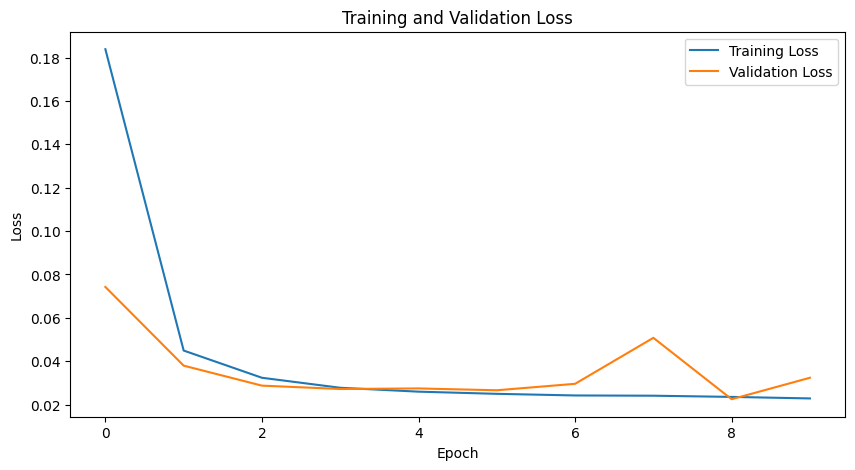

In [20]:
import matplotlib.pyplot as plt

# Визуализация графиков обучения
history = model.history

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

50/50 [==============================] - 5s 76ms/step


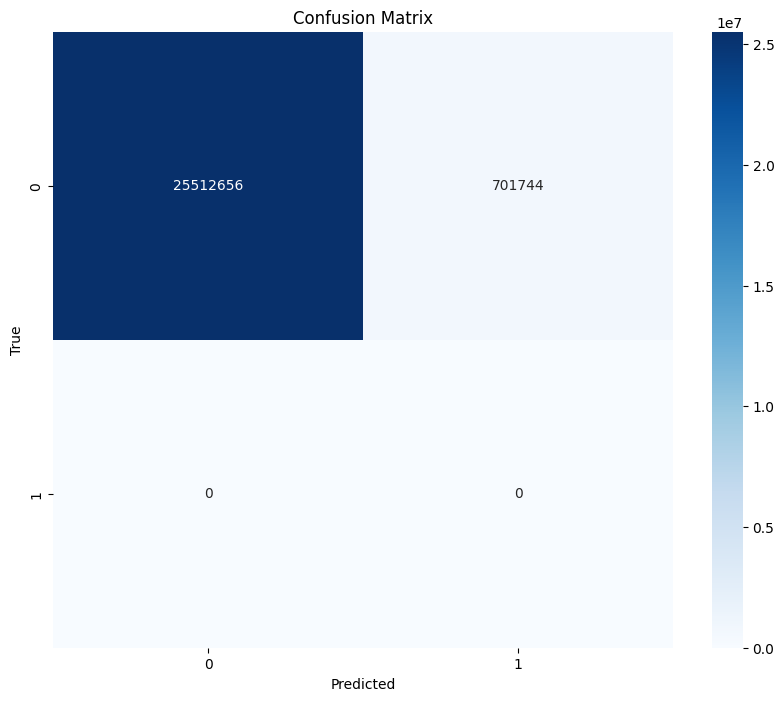

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Предсказание на тестовом наборе данных
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=-1)

# Истинные метки
y_true = []
for i in range(len(test_gen)):
    _, y_batch, _ = test_gen[i]
    y_true.extend(np.argmax(y_batch, axis=-1))

y_true = np.array(y_true)

# Сравнение предсказанных меток с истинными
conf_matrix = confusion_matrix(y_true.flatten(), y_pred_classes.flatten())

# Построение тепловой карты матрицы ошибок
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 2s 2s/step


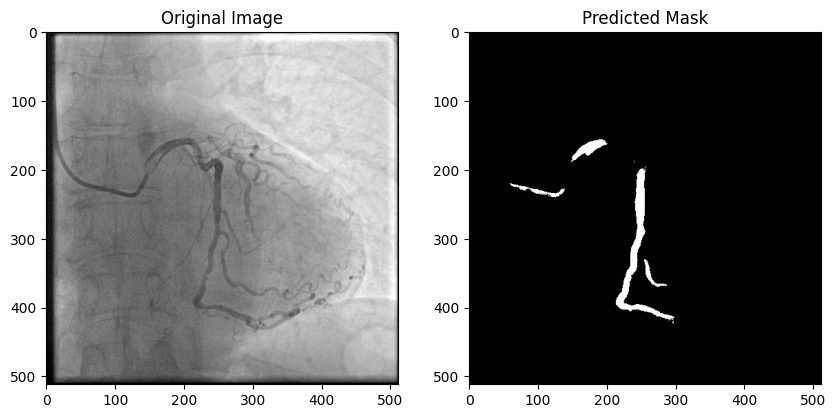

In [22]:
# Загрузка обученной модели
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Data/arcade/syntax/model/segmentation_model_100_epochs.keras')

# Загрузка нового изображения
new_image_path = '/content/drive/MyDrive/Data/arcade/syntax/test/images/1.png'
new_image = tf.keras.preprocessing.image.load_img(new_image_path, color_mode='grayscale', target_size=(512, 512))
new_image = tf.keras.preprocessing.image.img_to_array(new_image) / 255.0
new_image = np.expand_dims(new_image, axis=0)  # Добавление batch dimension

# Предсказание маски
prediction = model.predict(new_image)
predicted_mask = np.argmax(prediction, axis=-1)[0]

# Визуализация предсказанной маски
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(new_image[0, :, :, 0], cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Predicted Mask')
plt.imshow(predicted_mask, cmap='gray')
plt.show()


# Masks

In [12]:
import os
import cv2
import json
import numpy as np
from collections import defaultdict

# Путь к аннотациям COCO
coco_path = "/content/drive/MyDrive/Data/arcade/syntax/train/annotations/train.json"
# Папка с изображениями
images_folder = "/content/drive/MyDrive/Data/arcade/syntax/train/images"
# Папка для сохранения масок
masks_folder = "/content/drive/MyDrive/Data/arcade/syntax/train/masks"

# Создание папки для масок, если она не существует
if not os.path.exists(masks_folder):
    os.makedirs(masks_folder)

# Загрузка аннотаций COCO
with open(coco_path, encoding="utf-8") as file:
    gt = json.load(file)

im_anns_gt = defaultdict(list)
for ann in gt["annotations"]:
    im_anns_gt[ann["image_id"]].append(ann)

# Обработка и сохранение масок по одному изображению за раз
for img_info in gt["images"]:
    img_id = img_info["id"]
    img_filename = img_info["file_name"]

    # Создание пустой маски для текущего изображения
    mask = np.zeros((512, 512), np.int32)

    if img_id in im_anns_gt:
        for ann in im_anns_gt[img_id]:
            points = np.array([ann["segmentation"][0][::2], ann["segmentation"][0][1::2]], np.int32).T
            points = points.reshape((-1, 1, 2))
            tmp = np.zeros((512, 512), np.int32)
            cv2.fillPoly(tmp, [points], (1))
            mask += tmp
            mask[mask > 0] = 1

    # Сохранение маски
    mask_path = os.path.join(masks_folder, img_filename)
    cv2.imwrite(mask_path, (mask * 255).astype(np.uint8))

print("Маски успешно сохранены.")

Маски успешно сохранены.


# Masks to COCO

# COCO to yolo